<a href="https://colab.research.google.com/github/bscot/Broadband_tomography_with_CASTOR_and_SPEHREx/blob/main/LSST_u_band_exposures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [3]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [4]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["LSST-only"]

names = available_os

In [5]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [6]:
flows = FlowEnsemble(file=f"May_2024_runs/reruns_of_old_catalogs/pzflow_ensemble_for_LSST-only_z15to225.pkl")

In [87]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

LSST_baseline = Table.from_pandas(mock_cat) # apply magnitude limit cuts


In [93]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

ID = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=LSST_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [94]:
catalog = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_i_mag - LSST_y_mag,
                      }).set_index('CASTOR_ID').dropna()

In [55]:
from scipy import stats

In [95]:
extreme_mask = (np.abs(stats.zscore(catalog)) < 3).all(axis=1)
print(extreme_mask)

CASTOR_ID
1          True
2         False
3          True
5          True
12         True
          ...  
964428     True
964429     True
964437     True
964439     True
964449     True
Length: 413330, dtype: bool


In [96]:
# # 30 second mask

mask_30s = np.array(extreme_mask) & (LSST_u_mag < 25.14) & (LSST_g_mag < 26.62) & (LSST_r_mag < 26.82) & (LSST_i_mag < 26.38) & (LSST_z_mag < 25.73) & (LSST_y_mag < 24.77)

# put data in expected format for TLM

mask = mask_30s

LSST_u_mag = LSST_u_mag[mask]
LSST_g_mag = LSST_g_mag[mask]
LSST_r_mag = LSST_r_mag[mask]
LSST_i_mag = LSST_i_mag[mask]
LSST_z_mag = LSST_z_mag[mask]
LSST_y_mag = LSST_y_mag[mask]

ID = ID[mask]
z_true = z_true[mask]

# 38 second mask

# mask_38s = np.array(extreme_mask) & (LSST_u_mag < 25.42) & (LSST_g_mag < 26.62) & (LSST_r_mag < 26.80) & (LSST_i_mag < 26.37) & (LSST_z_mag < 25.70) & (LSST_y_mag < 24.76) #ns1p2

# put data in expected format for TLM

# mask = mask_38s

# LSST_u_mag = LSST_u_mag[mask]
# LSST_g_mag = LSST_g_mag[mask]
# LSST_r_mag = LSST_r_mag[mask]
# LSST_i_mag = LSST_i_mag[mask]
# LSST_z_mag = LSST_z_mag[mask]
# LSST_y_mag = LSST_y_mag[mask]

# ID = ID[mask]
# z_true = z_true[mask]

# 45 second mask

# # 25.49 26.61 26.79 26.36 25.70 24.75
# mask_45s = np.array(extreme_mask) & (LSST_u_mag < 25.49) & (LSST_g_mag < 26.61) & (LSST_r_mag < 26.79) & (LSST_i_mag < 26.36 ) & (LSST_z_mag < 25.70) & (LSST_y_mag < 24.75)

# # put data in expected format for TLM

# mask = mask_45s

# LSST_u_mag = LSST_u_mag[mask]
# LSST_g_mag = LSST_g_mag[mask]
# LSST_r_mag = LSST_r_mag[mask]
# LSST_i_mag = LSST_i_mag[mask]
# LSST_z_mag = LSST_z_mag[mask]
# LSST_y_mag = LSST_y_mag[mask]

# ID = ID[mask]
# z_true = z_true[mask]

In [97]:
catalog = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_i_mag - LSST_y_mag,
                      }).set_index('CASTOR_ID').dropna()

In [36]:
# 45 second catalog

catalog.describe()

,z_true,r,u-g,g-r,r-i,i-z,z-y
count,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000
mean,1.023061,23.858650,0.314457,0.359234,0.322719,0.233167,0.433304
std,0.526586,0.876524,0.228639,0.286728,0.239099,0.198555,0.269875
min,0.020100,21.153990,-0.476134,-0.454092,-0.300124,-0.366445,-0.395186
25%,0.646000,23.349987,0.149894,0.141002,0.134027,0.090169,0.234368
50%,0.952800,24.017589,0.270679,0.274529,0.266012,0.178842,0.387200
75%,1.346900,24.517430,0.445531,0.556564,0.508062,0.365640,0.625137
max,2.623600,25.723832,1.185687,1.324689,1.072922,0.846596,1.277651


In [98]:
# 30 second catalog

catalog.describe()

,z_true,r,u-g,g-r,r-i,i-z,z-y
count,78984.000000,78984.000000,78984.000000,78984.000000,78984.000000,78984.000000,78984.000000
mean,0.991117,23.630229,0.337410,0.384079,0.332558,0.236498,0.432464
std,0.522368,0.868992,0.268549,0.312839,0.244393,0.197551,0.270340
min,0.020100,21.153990,-1.401706,-0.799049,-0.530725,-0.588366,-0.837089
25%,0.604200,23.110563,0.157395,0.145616,0.139608,0.093715,0.236328
50%,0.929700,23.785453,0.278702,0.289203,0.276204,0.181348,0.385039
75%,1.301700,24.296783,0.459704,0.595169,0.520069,0.366645,0.617764
max,2.933100,25.722801,2.418870,1.687528,1.454954,1.224729,1.762469


In [101]:
just_tav = flows.log_prob(catalog, returnEnsemble = True)

In [46]:
just_tav

Array([[-22.535442, -24.348473, -24.448263, ..., -28.171417, -22.542658,
        -25.844677],
       [-17.570805, -23.6195  , -21.532064, ..., -20.781616, -18.987446,
        -17.526585],
       [-18.885357, -25.54377 , -24.382008, ..., -25.155418, -14.900528,
        -19.88356 ],
       ...,
       [-26.69201 , -39.928745, -37.98544 , ..., -39.810463, -30.523811,
        -28.15475 ],
       [-18.025436, -11.733923, -10.278018, ...,  -8.540791, -14.006098,
        -11.819328],
       [-18.440216, -21.87471 , -25.03233 , ..., -20.84896 , -24.714478,
        -25.827375]], dtype=float32)

In [21]:
import scipy.stats as sps

In [102]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)


      # print(os_names[os])
      # load the photometric catalog for this os
  cat = catalog
    # print(cat.shape)

  # Computing the entropy H(z)
  b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
  entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
  all_ent = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
  milb = just_tav
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
  all_milb = np.array(milb)
      # print(np.shape(all_milb[os]))
  all_tlm = milb.mean(axis=1) + entropy
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [103]:
all_tlm, is_inf_mask = compute_milb(just_tav, available_os)


['LSST-only']


<ipython-input-102-730c38fa774d>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [74]:
all_tlm.shape

(82877,)

In [85]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}


  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

  if 'logprob' not in catalog.columns.values:
    catalog['logprob'] = all_tlm


  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalog[(catalog['z_true'] >= zmin) & (catalog['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals[vals >   -3])
      # print(mean)
    std = np.std(vals[vals > -3])
    plotran[i] = mean
    ploterr[i] = std #len(vals))

  avgtav = plotran
  errtav = ploterr

  return avgtav, errtav

In [104]:
avgtav30s, errtav30s = bin_in_redshift(all_tlm, is_inf_mask)
# avgtav38s, errtav38s = bin_in_redshift(all_tlm, is_inf_mask)

# avgtav45s, errtav45s = bin_in_redshift(all_tlm, is_inf_mask)

(1.5, 2.25)

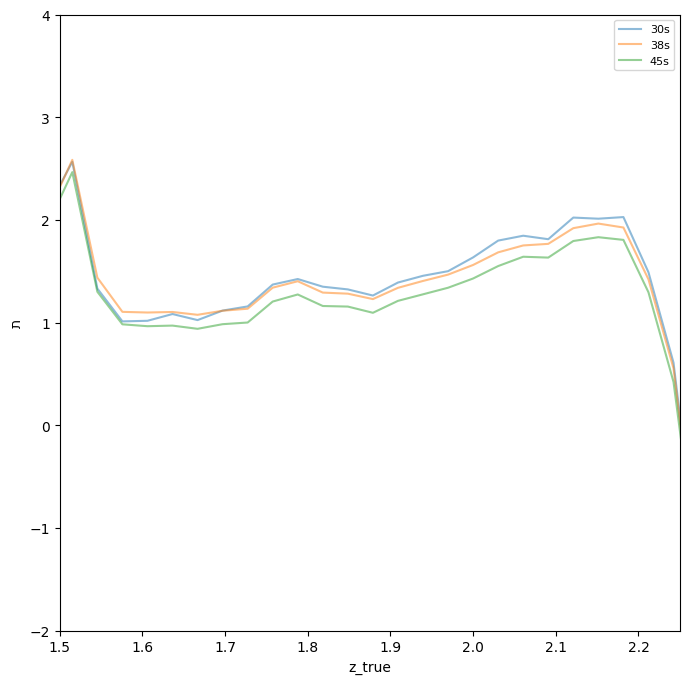

In [105]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

zbins = np.linspace(0, 3, 100)


for os in available_os:
  # print(np.min(avgtav))
  ax.plot(zbins, avgtav30s, alpha=0.5, label = '30s')
  ax.plot(zbins, avgtav38s, alpha=0.5, label = '38s')
  ax.plot(zbins, avgtav45s, alpha=0.5, label = '45s')
  # ax.fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax.legend(fontsize = 8)
ax.set_xlabel('z_true')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-2, 4)
ax.set_xlim(1.5, 2.25)